# Autograd, automatic differentiation, and adjoint optimization: basics

> Note: native autograd support is an experimental feature in tidy3d 2.7. To see the original implementation of this notebook using jax and the adjoint plugin, refer to [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

## Introduction

In this notebook, we will introduce the automatic differentiation feature of Tidy3D.
This feature allows users to take derivatives of arbitrary functions involving Tidy3D simulations through the use of the "adjoint method".
The advantage of the adjoint method is that the gradients can be computed using only **two** FDTD simulations, independent of the number of parameters.
This makes it possible to do gradient-based optimization or sensitivity analysis of devices with enormous numbers of parameters with minimal computational overhead.
For more information on the technical details of the adjoint method and what it can be used for, we recommend these references (with links to their pre-print versions):

* [Gradient-based "inverse design" optimization in photonics](https://arxiv.org/pdf/1801.06715.pdf).

* [Adjoint method for electromagnetics](https://arxiv.org/abs/1908.10507)

If you want to skip to some case studies of this technique being used for some applications, see the


* [Gradient Checking Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd2GradientChecking/).

* [Inverse Design Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd3InverseDesign/).

* [Multi-Objective Gradient Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd4MultiObjective/).

* [Boundary Gradients Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd5BoundaryGradients/).

* [Grating Coupler Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).


### Function differentiation

The adjoint package enables users to take derivatives of functions that involve a Tidy3D simulation. For a bit of context, let's first talk about what we mean when we talk about differentiating functions in our programs.
Say in our program we have programmatically defined a function of one variable $f(x)$. For example:
```py
def f(x):
   return x**2
```

Now, we wish to evaluate $\frac{df(x)}{dx}$.

If we know $\frac{df}{dx}$ analytically, this is just a matter of writing a new function to compute this derivative, for example:

```py
def df(x):
    return 2*x
```
However, many of the more interesting and complex functions tend to compose several sub-functions together, for example
$$f(x) = h(y) = h(g(x))$$
might be written in a program as

```py
def f(x):
    y = x**2
    return 5 * y - y**3
```

As one can imagine, defining the derivative by hand can quickly become too daunting of a task as the complexity grows.

However, we can simplify things greatly with knowledge of the derivatives of the simpler functions that make up $f$.
Following the chain rule, we can write the derivative of $f$ above as
$$\frac{df}{dx}=\frac{dh}{dy}\frac{dg}{dx}(x)$$

Thus, if we know the derivatives of the composite functions $h$ and $g$, we can construct the derivative of $f$ by multiplying all of the derivatives of the composite functions.
This idea is straightforwardly generalized to functions of several inputs and outputs, and even functions that can be written more generally as a more complex "computational graph" rather than a sequence of operations.

### Automatic differentiation

The idea of a technique called "automatic differentiation" is to provide a way to compute these derivatives of composite functions in programming languages both efficiently and without the user needing to define anything by hand.

Automatic differentiation works by defining "derivative rules" for each fundamental operation that the user might incorporate in his or her function. For example, derivative rules for `h` and `g`, in the example above may be used to help define the derivative for `f`. When the function is evaluated, all of the derivative information corresponding to each operation in the function are stitched together using the chain rule to construct a derivative for the entire function. Thus, functions of arbitrary complexity can be differentiated without deriving anything beyond just the derivative rules for the most basic operations contained within.

This capability is provided by many programming packages, but we chose to utilize one from the `autograd` package as it provides the flexibility and extendibility we needed for integrating this functionality into Tidy3D.

Using `autograd`, we may write a function $f$ using most of the fundamental operations in python and `numpy`. In `autograd` both the operations and their derivatives are tracked when the function is called. Thus, `autograd` gives the option to apply `autograd.grad` to this function, which uses all of the derivative information and the chain rule to construct a new function that gives the derivative of the function with respect to its input arguments.

In `tidy3d`, we can track functions **that involve Tidy3D simulations** in their computational graph. In essence, we privode the "derivative" of the `tidy3d.web.run()` function, using the adjoint method, to tell `autograd` how to differentiate functions that might involve both the setting up and postprocessing of a tidy3d simulation and its data. The end result is a framework where users can set up modeling and optimizations and utilize `autograd` automatic differentiation for optimization and sensitivity analysis efficiently and without needing to derive a single derivative rule.

In his notebook, we will give an overview of how `autograd` works for beginners and provide simple example of the plugin. More complex case studies and examples will be provided in other notebooks, linked here:

* [Gradient Checking Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd2GradientChecking/).

* [Inverse Design Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd3InverseDesign/).

* [Multi-Objective Gradient Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd4MultiObjective/).

* [Boundary Gradients Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd5BoundaryGradients/).

* [Grating Coupler Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).


## Automatic Differentiation using `autograd`

Before jumping into any Tidy3D simulations, we will give a bit of a primer on using `autograd` for automatic differentiation. 

First, we will import `autograd` and its `numpy` wrapper, which provides most of the same functionality, but allows derivative tracking.

Tip 1: if you run into an obscure error using `autograd`, the first thing to check is whether you're using the `autograd.numpy` wrapper instead of regular `numpy` in your function, as otherwise you will get errors from `autograd` that are not super clear.

In [5]:
import autograd as ag
import autograd.numpy as anp
import matplotlib.pylab as plt

Say we have a function $f$ that performs several operations on a single variable.

We can define this function `f` in python and also derive its derivative for this simple case, which we write as a function `df`.

In [3]:
def f(x):
    return 5 * anp.sin(x) - x**2 + x


def df(x):
    return 5 * anp.cos(x) - 2 * x + 1

Let's evaluate these functions at several points and plot them.

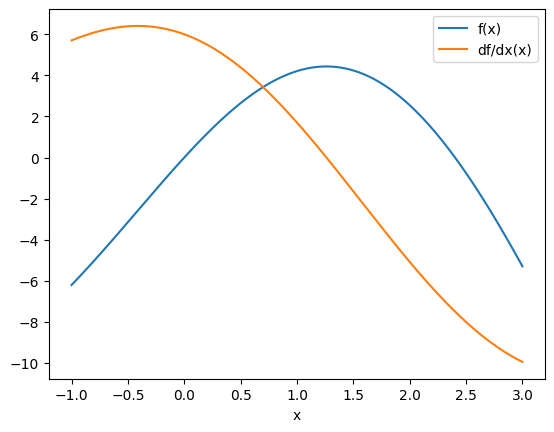

In [4]:
xs = anp.linspace(-1, 3, 1001)
plt.plot(xs, f(xs), label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x)")
plt.xlabel("x")
plt.legend()
plt.show()

Now let's use autograd to compute the derivative for us and see how it compares to our analytical derivative.

We first call `autograd.grad(f)`, which returns a new function that can be evaluated at `x` to give the derivative `df/dx(x)`.

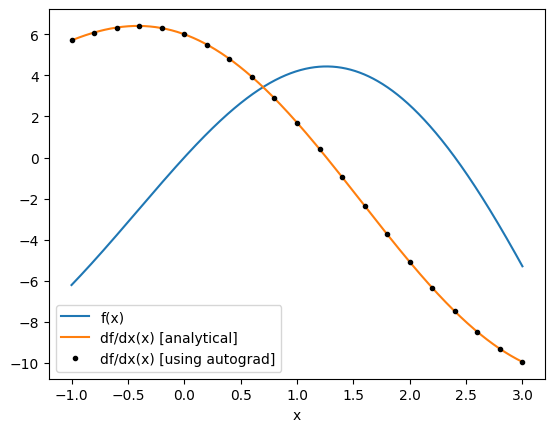

In [6]:
# get the gradient as a function of x
df_ag = ag.grad(f)

# get a set of points to feed the derivative function one by one (for now)
xs_ag = anp.linspace(-1, 3, 21)
df_ag_eval = [df_ag(x) for x in xs_ag]

plt.plot(xs, f(xs), label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x) [analytical]")
plt.plot(xs_ag, df_ag_eval, "k.", label="df/dx(x) [using autograd]")
plt.xlabel("x")
plt.legend()
plt.show()

Note: `autograd` provides several other useful gradient wrappers, which can be used in different contexts. 

For example `autograd.value_and_grad` returns both the function return value and the gradient value, which is useful to avoid repetitive computation if you need the value as the `autograd.grad` call must evaluate `f`.

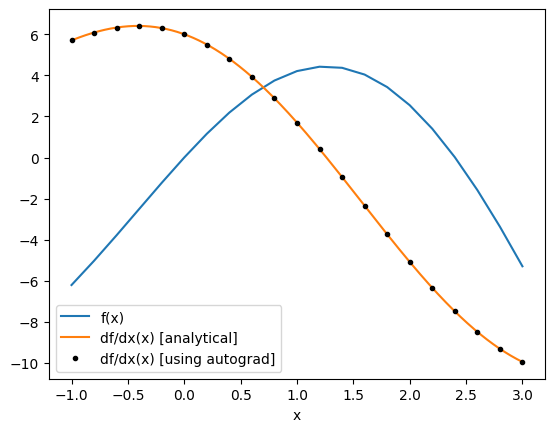

In [7]:
f_and_df = ag.value_and_grad(f)
vals_and_grads = [f_and_df(x) for x in xs_ag]
fs, dfs = list(zip(*vals_and_grads))

plt.plot(xs_ag, fs, label="f(x)")
plt.plot(xs, df(xs), label="df/dx(x) [analytical]")
plt.plot(xs_ag, df_ag_eval, "k.", label="df/dx(x) [using autograd]")
plt.xlabel("x")
plt.legend()
plt.show()

Before we continue, there are a few things to watch out for when using autograd for gradient calculation:

1.  `autograd.grad` doesn't automatically convert input arguments from `int` to `float`, so avoid passing `int` types to your functions.

In [8]:
# ok
print(df_ag(1.0))

# errors
try:
    df_ag(1)
except TypeError as e:
    print(repr(e))

1.7015115293406988
TypeError("Can't differentiate w.r.t. type <class 'int'>")


2. When differentiating with respect to several arguments, you need to tell `autograd.grad` which arguments you want to take the derivative with respect to as a tuple in indices. Otherwise it will take the derivative with respect to only the first argument.

In [9]:
def g(x, y, z):
    return x * y + z**2


# only gives dg/dx
dg = ag.grad(g)
dgdx = dg(1.0, 1.0, 1.0)
print(f"dgdx={dgdx}")

# gives derivative w.r.t. all three args
dg_all = ag.grad(g, argnum=(0, 1, 2))
dgdx, dgdy, dgdz = dg_all(1.0, 1.0, 1.0)
print(f"dgdx={dgdx}, dgdy={dgdy}, dgdz={dgdz}")

dgdx=1.0
dgdx=1.0, dgdy=1.0, dgdz=2.0


## Incorporating Automatic Differentiation in `Tidy3D`

With that basic introduction to automatic differentiation using `autograd`, we can now show how `Tidy3D` lets us do the same thing but where our functions can now involve setting up, running, and postprocessing a `tidy3d.Simulation`.

In [10]:
import tidy3d as td

td.config.logging_level = "INFO"

### Simulation example

In our example, we will set up a function that involves a simulation of transmission through a waveguide in the presence of a scatterer.

This scatterer geometry and material properties will depend on the function input arguments.

The output of the function will simply be the power transmitted into the 0th order mode.

We will then take the gradient of the output of this function (power) with respect to the scatterer geometric and medium properties using `autograd`.

To start, it can often be helpful to break our function up into a few parts for debugging.

Therefore, we will introduce one function to make the `td.Simulation` given the input arguments and one function to postprocess the result.

In [11]:
def make_simulation(center: tuple, size: tuple, eps: float) -> td.Simulation:
    """Makes a simulation with a variable scatter width, height, and relative permittivity."""

    wavelength = 1.0
    freq0 = td.C_0 / wavelength
    dl = 0.02

    # a "static" structure
    waveguide = td.Structure(
        geometry=td.Box(size=(td.inf, 0.3, 0.2)), medium=td.Medium(permittivity=2.0)
    )

    # our "forward" soruce
    mode_src = td.ModeSource(
        size=(0, 1.5, 1.5),
        center=(-0.9, 0, 0),
        mode_index=0,
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        direction="+",
    )

    # a monitor to store data that our overall function will depend on
    mode_mnt = td.ModeMonitor(
        size=(0, 1.5, 1.5),
        center=(+0.9, 0, 0),
        mode_spec=mode_src.mode_spec,
        freqs=[freq0],
        name="mode",
    )

    # the structure that depends on the input parameters, which we will differentiate our function w.r.t
    scatterer = td.Structure(
        geometry=td.Box(
            center=center,
            size=size,
        ),
        medium=td.Medium(permittivity=eps),
    )

    return td.Simulation(
        size=(2, 2, 2),
        run_time=1e-12,
        structures=[waveguide, scatterer],
        sources=[mode_src],
        monitors=[mode_mnt],
        boundary_spec=td.BoundarySpec.all_sides(td.PML()),
        grid_spec=td.GridSpec.uniform(dl=dl),
    )


Let's try setting up the simulation and plotting it for starters.

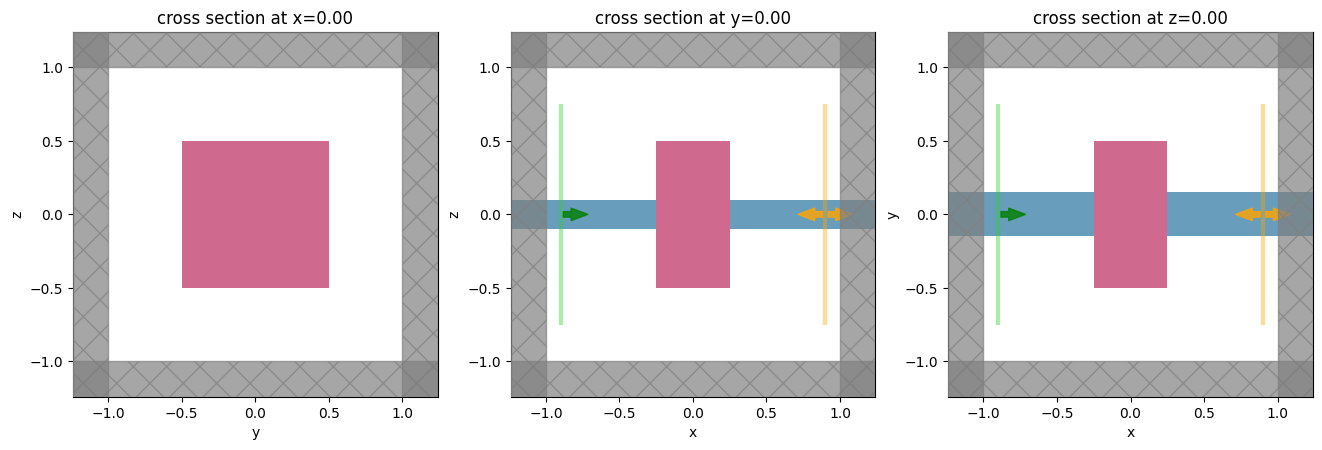

In [12]:
# starting set of input parameters
center0 = (0.0, 0.0, 0.0)
size0 = (0.5, 1.0, 1.0)
eps0 = 3.0

sim = make_simulation(center=center0, size=size0, eps=eps0)
_, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, dim in zip(axes, "xyz"):
    sim.plot(**{dim: 0}, ax=ax)
plt.show()

### Post-processing the output data

After the simulation is run, it returns a `td.SimulationData` containing the data we want to post-process.

Let's write a function that will process this `td.SimulationData` and return the power in the mode amplitude of our output mode monitor.

In [13]:
def compute_power(sim_data: td.SimulationData) -> float:
    """Post process the result of the Simulation run to return the power in the mode at index=0."""

    freq0 = sim_data.simulation.monitors[0].freqs[0]
    mode_data = sim_data["mode"]
    mode_amps = mode_data.amps
    amp = mode_amps.sel(direction="+", f=freq0, mode_index=0).values
    return anp.sum(abs(amp) ** 2)

### Defining the tidy3d simulation function for differentiation

Next, we can import the `tidy3d..web.run` function and put all the pieces together into a single function to compute the 0th order transmitted power as a function of `center`, `size`, and `eps` (relative permittivty) of the scatterer.

In [14]:
import tidy3d.web as web

11:43:14 CEST INFO: env_key is None

In [15]:
def power(center: tuple, size: tuple, eps: float) -> float:
    """Compute power transmitted into 0th order mode given a set of scatterer parameters."""
    sim = make_simulation(center=center, size=size, eps=eps)
    sim_data = web.run(sim, task_name="autograd 1")
    return compute_power(sim_data)

In [16]:
power(center0, size0, eps0)

11:43:24 CEST Created task 'autograd 1' with task_id                            
              'fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=150971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=491472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\taskId]8;;\]8;id=150971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\=]8;;\]8;id=23130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\fdve]8;;\]8;id=150971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\-0b1bd55e-e5]8;;\
              ]8;id=150971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\dd-4bb6-820e-d3c85e0e8b21']8;;\.

Output()

11:43:33 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

11:43:59 CEST status = preprocess

11:44:00 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

11:44:05 CEST early shutoff detected at 8%, exiting.

              status = success

              View simulation result at                                         
              ]8;id=23383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=78547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\taskId]8;;\]8;id=23383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\=]8;;\]8;id=334330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\fdve]8;;\]8;id=23383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\-0b1bd55e-e5]8;;\
              ]8;id=23383;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0b1bd55e-e5dd-4bb6-820e-d3c85e0e8b21\dd-4bb6-820e-d3c85e0e8b21']8;;\.

Output()

11:44:07 CEST loading simulation from simulation_data.hdf5

0.5520313810023142

### Running and differentiating the simulation using `autograd`

Finally, using the `autograd` tools described earlier, we can differentiate this `power` function. 

For demonstration, let's use `autograd.value_and_grad` to both compute the power **and** the gradient w.r.t. each of the 3 input parameters.

In [17]:
d_power = ag.value_and_grad(power, argnum=(0, 1, 2))

We will run this function and assign variables to the power values and the gradients returned.

Note that running this will set off **two** separate tasks, one after another, called, `"adjoint_power_fwd"` and `"adjoint_power_adj"`.

The first is evaluating our simulation in "forward mode", computing the power and stashing information needed for gradient computation.

The second step runs the "adjoint" simulation, in which the output monitor is converted to a source and the simulation is re-run.

The results of both of these simulations runs are combined behind the scene to tell `autograd` how to compute the gradient for us.

In [18]:
power_value, (dp_dcenter, dp_dsize, dp_deps) = d_power(center0, size0, eps0)

11:44:23 CEST INFO: running primitive '_run_primitive()'

              INFO: running regular simulation with '_run_tidy3d()'

              Created task 'autograd 1' with task_id                            
              'fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=216935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=513165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\taskId]8;;\]8;id=216935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\=]8;;\]8;id=78033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\fdve]8;;\]8;id=216935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\-09e01802-8b]8;;\
              ]8;id=216935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\37-43eb-8c02-3ad08a8abaf5']8;;\.

Output()

11:44:26 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

11:44:29 CEST status = preprocess

11:44:31 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

11:44:36 CEST early shutoff detected at 8%, exiting.

              status = postprocess

Output()

11:44:39 CEST status = success

              View simulation result at                                         
              ]8;id=888800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=809692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\taskId]8;;\]8;id=888800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\=]8;;\]8;id=285881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\fdve]8;;\]8;id=888800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\-09e01802-8b]8;;\
              ]8;id=888800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09e01802-8b37-43eb-8c02-3ad08a8abaf5\37-43eb-8c02-3ad08a8abaf5']8;;\.

Output()

11:44:42 CEST loading simulation from simulation_data.hdf5

              INFO:  -> 1 monitors, 1 adjoint field monitors, 1 adjoint eps     
              monitors.

              INFO: constructing custom vjp function for backwards pass.

              INFO: Running custom vjp (adjoint) pipeline.

              INFO: Adjoint simulation created with 1 sources.

              INFO: running regular simulation with '_run_tidy3d()'

              Created task 'autograd 1_adjoint' with task_id                    
              'fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=355745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=129818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\taskId]8;;\]8;id=355745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\=]8;;\]8;id=732148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\fdve]8;;\]8;id=355745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\-d1e1552d-0c]8;;\
              ]8;id=355745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\ba-4431-91e7-1e294ce5b7f7']8;;\.

Output()

11:44:44 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

11:44:47 CEST status = preprocess

11:44:50 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

Output()

11:44:54 CEST early shutoff detected at 8%, exiting.

              status = postprocess

Output()

11:44:58 CEST status = success

11:44:59 CEST View simulation result at                                         
              ]8;id=110531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=510436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\taskId]8;;\]8;id=110531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\=]8;;\]8;id=797211;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\fdve]8;;\]8;id=110531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\-d1e1552d-0c]8;;\
              ]8;id=110531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d1e1552d-0cba-4431-91e7-1e294ce5b7f7\ba-4431-91e7-1e294ce5b7f7']8;;\.

Output()

11:45:06 CEST loading simulation from simulation_data.hdf5

> Note: the gradient evaluation functions returned by `autograd.grad()` do not accept keyword arguments (ie. `center=(0.,0.,0.)`) and instead accept positional arguments (without the argument name). You may run across this when trying to evaluate gradients so it's a good idea to keep in mind.

We can take a look at our computed power and gradient information. 

In [19]:
print(f"power = {power_value:.3f}")
print(f"d_power/d_center = {dp_dcenter}")
print(f"d_power/d_size = {dp_dsize}")
print(f"d_power/d_eps = {dp_deps}")

power = 0.552
d_power/d_center = (array(0.00118849), array(1.05986359e-05), array(-0.00056509))
d_power/d_size = (array(-0.01352494), array(0.1254442), array(-0.1322356))
d_power/d_eps = -0.16138065820073802


From this, we can infer several things that fit our intuition, for example that:
* the transmitted power should **decrease** if we increase the permittivity of our scatterer.
* the transmitted power does not depend strongly on the position of the scatterer along the propagation direction.

## Conclusion & Next Steps

This gives the most basic introduction to the principles behind the adjoint plugin.

In subsequent notebooks, we will show how to:
 * Check the gradients returned by this method against brute force computed gradients for accuracy.
 * Perform gradient-based optimization using the adjoint plugin.